# Facebook recruit: Human or Bots

### Nguyen Dang Minh, PhD 

* [**1. Introduction**](#ch1)

* [**2. Import and greet the data**](#ch2)
    * [2.1. The bids data set](#ch2.1)
    * [2.2. The train and test set](#ch2.2)
    
* [**3. Features extraction**](#ch3)
    * [3.1. General processing](#ch3.1)
    * [3.2. Numbers of bids made](#ch3.2)
    * [3.3. Auctions](#ch3.3)
    * [3.4. Device, country, IP](#ch3.4)
    * [3.5. URL](#ch3.5)
    * [3.6. Action time](#3.6)
    * [3.7. Reaction time](#3.7)
    * [3.8. Merchandise](#3.8)
    * [3.9. Finalize the processed data](#3.9)
    
* [**4. Building the machine learning model**](#ch4)
    * [4.1. Viewing the train test set](#ch4.1)
    * [4.2. Handling the unbalanced data](#4.2)
    * [4.3. Building the models](#ch4.3)
    
* [**5. Analyze the results**](#ch5)
    * [5.1. The ROC curve](#ch5.1)
    * [5.2. Features importance](#ch5.2)
    * [5.3. Conclusion](#ch5.3)

<a id="ch1"></a>

## 1. Introduction

This is a self-practice project, following the Kaggle's competition [Facebook Recruiting IV: Human or Robot?](https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot).

The concept of the problem is that we have a platform that is organizing online auctions. Here people can conveniently create an account to participate through their phone and make the bids in multiple auctions. However, one issue is that some are trying to win by making bots doing the bidding job. Our task is to identify which account belongs to real people and which are controlled by the bots.


<img src='auction.png'/>
<center><em> Can we tell which bidders are robots? </em></center>

We are provided with three sets of data. The first set is **bids.csv** which contains all information about every bids made, such as bidder ids, auction id, time, device, ip address, etc. The second set is **train.csv** which contains information about bidders who has been identified as human/robot. This is our training data. The last set is **test.csv** where bidders there has not yet been identified and it is our job to classify them. Here the work is divided into two parts. In the first part, we analyze and process the data to extract important features. In the second part, based on the extracted feature, we build a machine learning model to give prediction on the test set and gain insights about the different bidding behaviors of human and robots.

<a id="ch2"></a>

## 2. Import and greet the data

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib import rcParams

rcParams['font.size'] = 14

<a id="ch2.1"></a>

### 2.1. The bids data set

Since this notebook is run on a personal computer with limited processing power, **here we use only 1/10 of the data set for visualizing the processing step**. The complete data has been run in full in advance and the results has been stored separately for later calculations.

In [2]:
# Import 1/10 of the data set
random.seed(1)
sample_size = int(7.66e6)
desired_size = int(sample_size/10)
skip = sorted(random.sample(range(2,sample_size),sample_size-desired_size)) 
bids_orig = pd.read_csv('Data_raw/bids.csv', skiprows = skip)
del skip

In [3]:
bids_orig.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,16,1a9c554b044c77239b63636008d353d4vy9kh,xk5nb,mobile,phone16,9759243263157894,in,130.252.241.92,z0xsd05zh5z8j7l
2,27,aa5f360084278b35d746fa6af3a7a1a5ra3xe,88xe3,home goods,phone24,9759243315789473,ch,144.203.164.7,526pa711hpwgwta
3,33,a58ace8b671a7531c88814bc86b2a34cf0crb,cqcep,sporting goods,phone31,9759243315789473,za,220.231.174.196,pq96f16urkbpklz
4,46,6c8ffec692e88d81e1b18d47818abb04v6llr,ewmzr,home goods,phone8,9759243368421052,us,160.9.191.22,lok9xfe6k6rtv8f


In [4]:
list(bids_orig)

['bid_id',
 'bidder_id',
 'auction',
 'merchandise',
 'device',
 'time',
 'country',
 'ip',
 'url']

In [5]:
print('Number of bids made: %i' %bids_orig['bidder_id'].count())

Number of bids made: 765619


In [6]:
print('Number of bidders: %i' %bids_orig['bidder_id'].nunique())

Number of bidders: 4371


In this reduced data set, there are 765619 bids, made by 4371 bidders. With each bids made, the system store the following information:
* **`bid_id`**: unique identifier of each bid
* **`bidder_id`**: unique identifier of the bidder. This information has been encoded.
* **`auction`**: unique identifier of the auction in which the bid was made. A bidder can participate in multiple auctions
* **`merchandise`**: product categories that originally guide the bidder to the bidding site. Each bidder only has one type or merchandise.
* **`device`**: phone model of the bidder
* **`time`**: time that the bid is made. This information has been encoded, but the encoded values is still proportional to the real value.
* **`country`**: the country that the IP belongs to
* **`ip`**: ip address of the bidder
* **`url`**: url of the site where the bidder made the bid

<a id="ch2.2"></a>
### 2.2. The train and test set

In [7]:
# Import the train set
train_orig = pd.read_csv('Data_raw/train.csv')
train_orig.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [8]:
print('Number of bidders in train sets: %i' %train_orig['bidder_id'].count())
print('Number of unique payment account: %i' %train_orig['payment_account'].nunique())
print('Number of unique address: %i' %train_orig['address'].nunique())

Number of bidders in train sets: 2013
Number of unique payment account: 2013
Number of unique address: 2013


There are 2013 bidders in the train set. Not every bidder in the train set has made their bid and is presented in the bids data set. Each bidder has an unique **`payment_account`** and **`address`**, thus these two information will not contribute to our analysis and we can ignore them.

In [9]:
train = train_orig.drop(columns=['payment_account', 'address'])

We can also import the test set and process them side by side with the train set for easier processing when building the model.

In [10]:
# Import test set
test_orig = pd.read_csv('Data_raw/test.csv')
test = test_orig.drop(columns=['payment_account', 'address'])

<a id="ch3"></a>

## 3. Features extraction

<a id="ch3.1"></a>

### 3.1. General processing

First let fill all the empty data.

In [11]:
bids_orig.isnull().sum()

bid_id           0
bidder_id        0
auction          0
merchandise      0
device           0
time             0
country        897
ip               0
url              0
dtype: int64

All small number of bids has their country unidentified. We fill the empty hole with `"0"`, indicating another, unidentified country.

In [12]:
# Fill nan
bids_fillna = bids_orig.fillna('0')

In [13]:
# Sort bids data by bidder_id and time
bids_sorted = bids_fillna.sort_values(by=['bidder_id', 'time'], ascending=[True, True])

# Bidder ids
bidder_ids = bids_sorted['bidder_id'].unique()

In [14]:
# General data extracting and plotting function
def plot_distribution(dataframe, nb_show=10, xlabel=None, ylabel='Percent', title=None, percentage=True):
    column0 = dataframe.columns[0]
    column1 = dataframe.columns[1]
    data_plot = dataframe.sort_values(by=column1, ascending=False)
    data_plot[column0] = data_plot.apply(lambda x: x[column0][:10], axis=1)
    if percentage==True:
        data_plot[column1] = data_plot[column1]/data_plot[column1].sum()*100
    x = np.arange(nb_show)
    plt.figure(figsize=(10,6))
    plt.bar(x,data_plot.iloc[:nb_show, 1].values)
    plt.xticks(x, data_plot.iloc[:nb_show,0], rotation='vertical')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    
def get_data(line, datagrouped, id_list):
    if line['bidder_id'] in id_list:
        return data_grouped[line['bidder_id']]
    else:
        return 0

<a id="ch3.2"></a>

### 3.2. Numbers of bids made

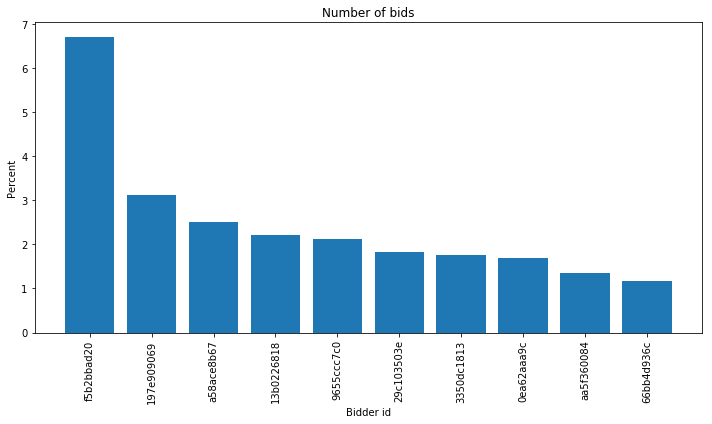

In [15]:
bids_data = bids_sorted[['bidder_id','bid_id']].groupby('bidder_id', as_index=False).count()
plot_distribution(bids_data, title='Number of bids', xlabel='Bidder id')

There are some major bidders in the platform. Here we extract the first feature:
* **`nb_bids`**: the number of bids made in the session

If bidders does not exist in bids data then this value is set to be 0

In [16]:
# Extract number of bids
data_grouped = bids_sorted[['bidder_id','bid_id']].groupby('bidder_id').count()['bid_id']
train['nb_bids'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['nb_bids'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)

<a id="ch3.3"></a>

### 3.3. Auctions

Total numbers of auction: 11565


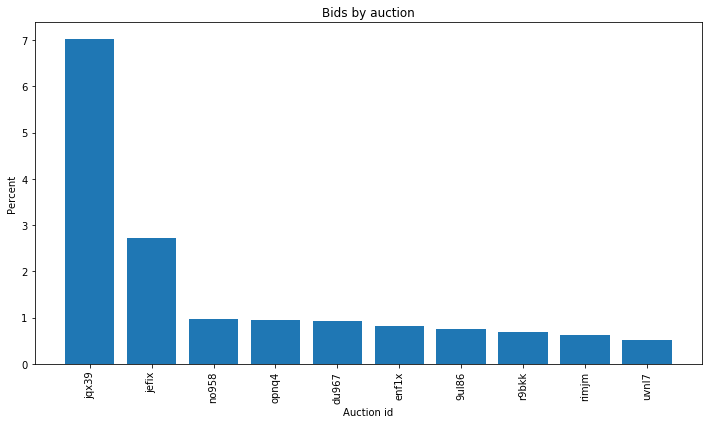

In [17]:
auction_data = bids_sorted[['auction','bid_id']].groupby('auction', as_index=False).count()
plot_distribution(auction_data, xlabel='Auction id', title='Bids by auction')
print('Total numbers of auction: %i' %len(auction_data))

Here for each bidder we retrieve the following features:
* **`nb_auctions`**: number of auctions taking part in
* **`nb_won`**: number of auctions won, defined as the auction we the bidder make the last bid.
* **`max_bids`**: maximum number of bids the bidder make in a single auction

If bidders does not exist in bids data then these values is set to be 0

In [18]:
# Number of auction taking part in
data_grouped = bids_sorted[['bidder_id', 'auction']].groupby('bidder_id').nunique()['auction'] 
train['nb_auctions'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['nb_auctions'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)

# Number of auction won
winners = bids_sorted[['bidder_id','auction','time']].sort_values(['auction','time'], ascending=True)\
                .groupby('auction').last()
data_grouped = winners.groupby('bidder_id').count()['time']
winners_id = winners['bidder_id'].unique()   
train['nb_won'] = train.apply(lambda x: get_data(x, data_grouped, winners_id), axis=1)
test['nb_won'] = test.apply(lambda x: get_data(x, data_grouped, winners_id), axis=1)

# Highest numbers of bid in an auction
bids_by_auction = bids_sorted[['bidder_id','auction','bid_id']]\
                .groupby(['bidder_id', 'auction'], as_index=False).count()
data_grouped = bids_by_auction.groupby('bidder_id').max()['bid_id']    
train['max_bids'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['max_bids'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)

<a id="ch3.4"></a>

### 3.4. Device, country, IP

The detailed value of these columns are not important. Here we extract the following features:
* **`nb_devices`**: number of devices used by this bidder
* **`nb_ips`**: number of IP address used by this bidder
* **`nb_countries`**: number of countries declared by this bidder

If bidders does not exist in bids data then these values is set to be 0

Total number of countries detected: 191


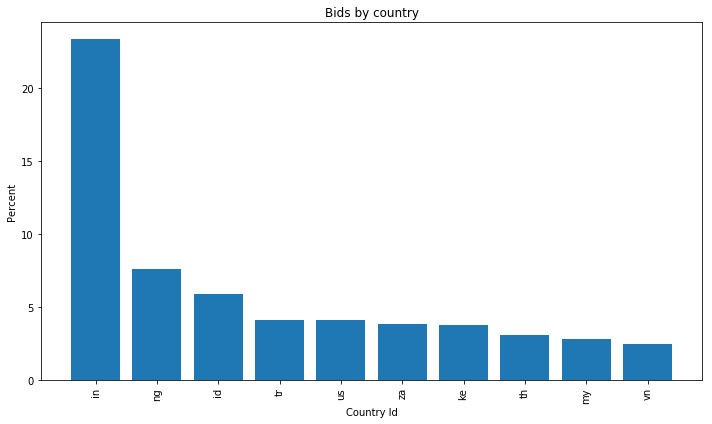

In [19]:
# Number of devices
data_grouped = bids_sorted[['bidder_id','device']].groupby('bidder_id').nunique()['device']
train['nb_devices'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['nb_devices'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)

# Number of IPs
data_grouped = bids_sorted[['bidder_id','ip']].groupby('bidder_id').nunique()['ip'] 
train['nb_ips'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['nb_ips'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)

# Number of countries
country_data = bids_sorted[['country','bid_id']].groupby('country', as_index=False).count()
print('Total number of countries detected: %i'%len(country_data))
plot_distribution(country_data, xlabel='Country Id', title='Bids by country')

data_grouped = bids_sorted[['bidder_id','country']].groupby('bidder_id').nunique()['country']  
train['nb_countries'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['nb_countries'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)


<a id="ch3.5"></a>

### 3.5. URL


Total number of url detected: 246933


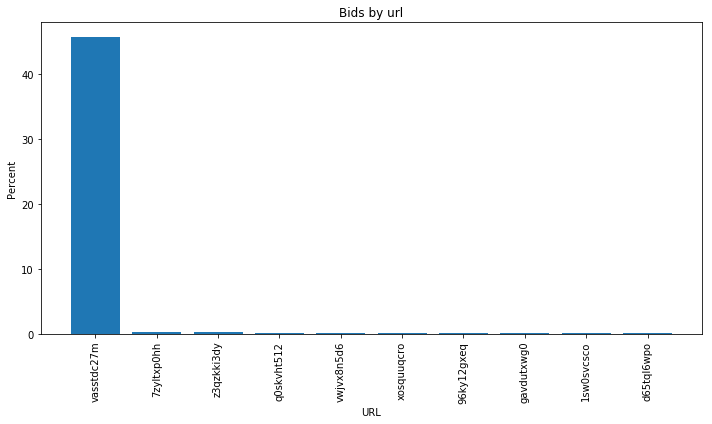

In [20]:
url_data = bids_sorted[['url','bid_id']].groupby('url', as_index=False).count()
print('Total number of url detected: %i'%len(url_data))
plot_distribution(url_data, xlabel='URL', title='Bids by url')

A lot of bids come from a major URL, most likely belong to the main bidding website. Here we extract the following features:
* **`nb_urls`**: number of url used by this bidder
* **`ratio_main_url`**: how many bids made by this bidder come from the main url.

In [21]:
# Number of URL
data_grouped = bids_sorted[['bidder_id','url']].groupby('bidder_id').nunique()['url']
train['nb_urls'] = train.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)
test['nb_urls'] = test.apply(lambda x: get_data(x, data_grouped, bidder_ids), axis=1)

# Fraction of URL from the main URL
main_url = bids_sorted['url'].value_counts(normalize=True).idxmax()
main_url_bids = bids_sorted[bids_sorted['url']==main_url]
main_url_bidders = main_url_bids['bidder_id'].unique()
data_grouped = main_url_bids[['bidder_id','url']].groupby('bidder_id').count()['url']
def ratio_main_url(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in main_url_bidders:
        return data_grouped[line['bidder_id']]/line['nb_bids']
    else:
        return 0

train['ratio_main_url'] = train.apply(lambda x: ratio_main_url(x, data_grouped, main_url_bidders), axis=1)
test['ratio_main_url'] = test.apply(lambda x: ratio_main_url(x, data_grouped, main_url_bidders), axis=1)


<a id="ch3.6"></a>

### 3.6. Action time

Action time of a bidder is defined as the time between two consecutive bids of that bidder taking into account all the auctions.

/home/dmdm02/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


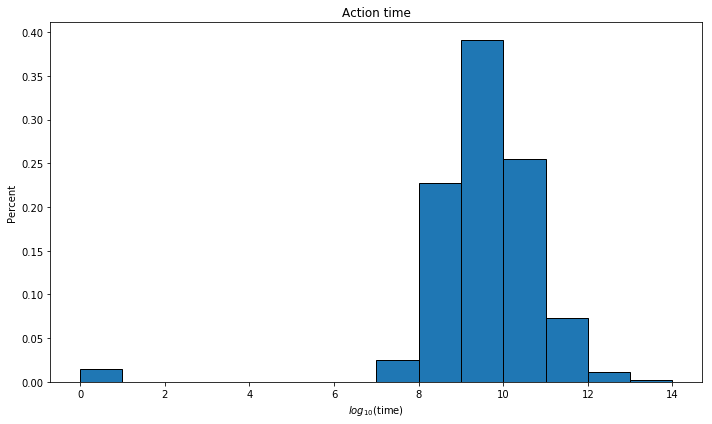

In [41]:
# Get action time
bids_time = bids_sorted[['bidder_id','time']]
bids_time['diff'] = bids_sorted[['bidder_id','time']].groupby('bidder_id', as_index=False).diff()
bids_time = bids_time.dropna()
max_action_time = bids_time['diff'].max()

act_time_plot = np.log10(bids_time['diff']+1)
plt.figure(figsize=(10,6))
plt.hist(act_time_plot, bins=np.arange(0,15,1), density=True, edgecolor='black')
plt.xlabel('$log_{10}$(time)')
plt.ylabel('Percent')
plt.title('Action time')
plt.tight_layout()

The majority of action time is at the order of $10^{10}$, but there are some bidders that make two bids instantaneously. The hypothesis is that machines should have shorter and more unique action time. Of course, there can be cases that a group of people control the same account to make multiple bids at once. In such case the action time can also be zero. The major bidder that cover 7% of total bids falls into this case: bids a lot and very fast, but still verified as human.

Here we retrieve the following information:
* **`min_action_time`**: the minimum action time of this bidder. For those who are not in the bids data, this value is set to be maximum.
* **`mean_action_time`**: the mean action time of this bidder. For those who are not in the bids data, this value is set to be maximum.
* **`unique_action_time`**: the numbers of unique action time of this bidder. For those who are not in bids data, this value is set to be 1.

In [24]:
# Min action time
data_grouped = bids_time[['bidder_id','diff']].groupby('bidder_id').min()['diff']
def min_action_time(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return max_action_time
train['min_action_time'] = train.apply(lambda x: min_action_time(x, data_grouped, bidder_ids), axis=1)
test['min_action_time'] = test.apply(lambda x: min_action_time(x, data_grouped, bidder_ids), axis=1)

# Mean action time
data_grouped = bids_time[['bidder_id','diff']].groupby('bidder_id').mean()['diff']
def mean_action_time(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return max_action_time
train['mean_action_time'] = train.apply(lambda x: mean_action_time(x, data_grouped, bidder_ids), axis=1)
test['mean_action_time'] = test.apply(lambda x: mean_action_time(x, data_grouped, bidder_ids), axis=1)

# Unique action time
data_grouped = bids_time[['bidder_id','diff']].groupby('bidder_id').nunique()['diff']
def unique_action_time(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return 1
train['unique_action_time'] = train.apply(lambda x: unique_action_time(x, data_grouped, bidder_ids), axis=1)
test['unique_action_time'] = test.apply(lambda x: unique_action_time(x, data_grouped, bidder_ids), axis=1)

<a id="ch3.7"></a>

### 3.7. Reaction time

Similar to action time, reaction time can be an indicator to differentiate human/robot. Here reaction time is defined as the time it takes for the bidder to react and counter the previous bid make by another bidder in the same auction.

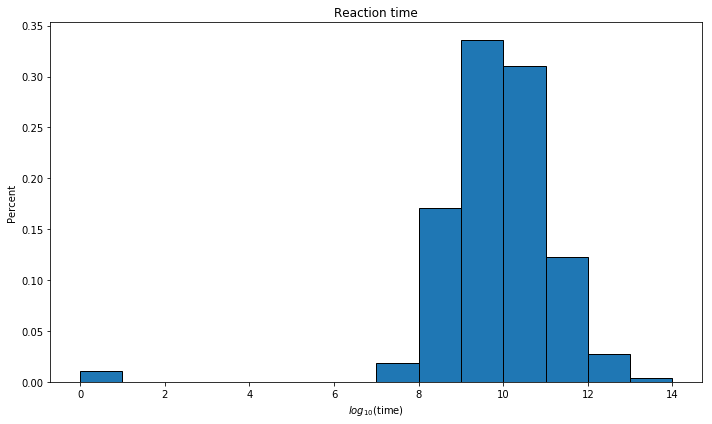

In [38]:
bids_time = bids_sorted[['bidder_id','time','auction']].sort_values(by=['auction','time'])
bids_time['diff'] = bids_time.groupby('auction', as_index=False).diff()
bids_time = bids_time.dropna()
max_react_time = bids_time['diff'].max()

react_time_plot = np.log10(bids_time['diff']+1)
plt.figure(figsize=(10,6))
plt.hist(react_time_plot, bins=np.arange(0,15,1), density=True, edgecolor='black')
plt.xlabel('$log_{10}$(time)')
plt.ylabel('Percent')
plt.title('Reaction time')
plt.tight_layout()

Here we retrieve the following information:
* **`min_react_time`**: the minimum reaction time of this bidder. For those who are not in the bids data, this value is set to be maximum.
* **`mean_react_time`**: the mean reaction time of this bidder. For those who are not in the bids data, this value is set to be maximum.
* **`unique_react_time`**: the numbers of unique reaction time of this bidder. For those who are not in bids data, this value is set to be 1.

In [27]:
# Min reaction time
data_grouped = bids_time[['bidder_id','diff']].groupby('bidder_id').min()['diff']
def min_react_time(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return max_react_time
train['min_react_time'] = train.apply(lambda x: min_react_time(x, data_grouped, bidder_ids), axis=1)
test['min_react_time'] = test.apply(lambda x: min_react_time(x, data_grouped, bidder_ids), axis=1)

# Mean reaction time
data_grouped = bids_time[['bidder_id','diff']].groupby('bidder_id').mean()['diff']
def mean_react_time(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return max_react_time
train['mean_react_time'] = train.apply(lambda x: mean_react_time(x, data_grouped, bidder_ids), axis=1)
test['mean_react_time'] = test.apply(lambda x: mean_react_time(x, data_grouped, bidder_ids), axis=1)

# Unique reaction time
data_grouped = bids_time[['bidder_id','diff']].groupby('bidder_id').nunique()['diff']
def unique_react_time(line, data_grouped, main_url_bidders):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return 1    
train['unique_react_time'] = train.apply(lambda x: unique_react_time(x, data_grouped, bidder_ids), axis=1)
test['unique_react_time'] = test.apply(lambda x: unique_react_time(x, data_grouped, bidder_ids), axis=1)

<a id="ch3.8"></a>

### 3.8. Merchandise

Numbers of merchandise: 10


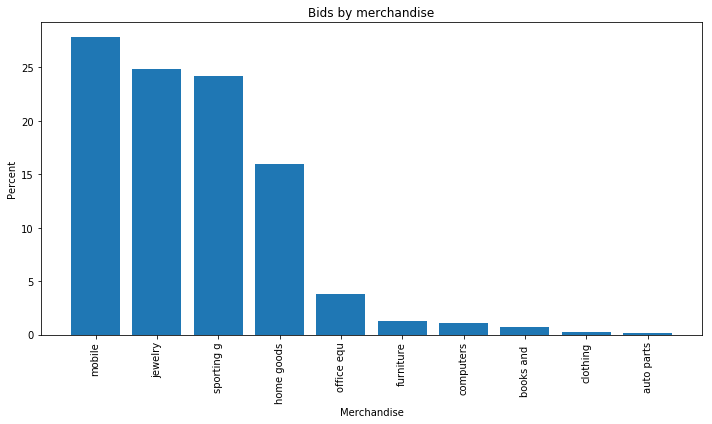

In [28]:
merchandise_data = bids_sorted[['merchandise','bid_id']].groupby('merchandise', as_index=False).count()
print('Numbers of merchandise: %i' %len(merchandise_data))
plot_distribution(merchandise_data, xlabel='Merchandise', title='Bids by merchandise')

Each bidder only has one merchandise. Here we retrieve the following information:
* **`merchandise`**: the merchandise of the bidder. If the bidder is not in the bid data, then the value is set to the most popular merchandise, which is mobile.

In [29]:
data_grouped = bids_sorted[['bidder_id','merchandise']].groupby('bidder_id').first()['merchandise']
popular_merchandise = data_grouped.value_counts().idxmax()

def get_merchandise(line, data_grouped, bidder_ids):
    if line['bidder_id'] in data_grouped.index:
        return data_grouped[line['bidder_id']]
    else:
        return popular_merchandise
train['merchandise'] = train.apply(lambda x: get_merchandise(x, data_grouped, bidder_ids), axis=1)
test['merchandise'] = test.apply(lambda x: get_merchandise(x, data_grouped, bidder_ids), axis=1)
train[['outcome','merchandise']].groupby('merchandise').mean().sort_values(by='outcome', ascending=False)

,outcome
merchandise,
computers,0.208333
sporting goods,0.103586
home goods,0.095238
office equipment,0.089888
books and music,0.089286
jewelry,0.047809
mobile,0.029046
auto parts,0.000000
clothing,0.000000


There is no robot in auto parts, clothing and furniture. Thus we group them into the same category named 'others', and perform label encoding to this column.

In [33]:
train_cat = train.replace({'merchandise':['auto parts','furniture','clothing']},'others')
train_cat = pd.get_dummies(train_cat, columns=['merchandise'])
test_cat = test.replace({'merchandise':['auto parts','furniture','clothing']},'others')
test_cat = pd.get_dummies(test_cat, columns=['merchandise'])

<a id="ch3.9"></a>

### 3.9. Finalize the processed data
The processing part has completed. We have retrieve all the information that is needed. Now let's take a look at the processed data:

In [35]:
train_cat.head()

,bidder_id,outcome,nb_bids,nb_auctions,nb_won,max_bids,nb_devices,nb_ips,nb_countries,nb_urls,...,mean_react_time,unique_react_time,merchandise_books and music,merchandise_computers,merchandise_home goods,merchandise_jewelry,merchandise_mobile,merchandise_office equipment,merchandise_others,merchandise_sporting goods
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,8,7,1,2,5,7,5,1,...,5.559737e+11,8,0,0,1,0,0,0,0,0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,0,0,0,0,0,0,0,0,...,7.597411e+13,1,0,0,0,0,1,0,0,0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,0,0,0,0,0,0,0,0,...,7.597411e+13,1,0,0,0,0,1,0,0,0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,0,0,0,0,0,0,0,0,...,7.597411e+13,1,0,0,0,0,1,0,0,0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,13,9,0,3,10,13,1,9,...,8.846154e+09,12,0,0,0,0,0,1,0,0


Each bidder has 23 features that decides on the outcome. These processed data is then saved to a file for later processing step.

In [39]:
train_cat.to_csv('train.csv', index=False)
test_cat.to_csv('test.csv', index=False)

The full data set has been preprocessed and saved. Now let's import it here:

In [2]:
train = pd.read_csv('Data_processed/train.csv')
test = pd.read_csv('Data_processed/test.csv')

Brief look on the potential contribution of each feature onto the final prediction

In [6]:
train_compare = train.iloc[:,1:17]
compare_table = train_compare.groupby('outcome').mean().transpose()
compare_table.columns = ['Human','Robot']
def comment(line):
    x = line['Human']/line['Robot']
    if x>2.5 or x<1/2.5:
        return "Differentiator"
    else:
        return "Not sure"
    
compare_table['Comment'] = compare_table.apply(lambda x: comment(x), axis=1)
compare_table.head(17)

,Human,Robot,Comment
nb_bids,1.392046e+03,4.004039e+03,Differentiator
nb_auctions,5.718901e+01,1.450388e+02,Differentiator
nb_won,2.627749e+00,7.854369e+00,Differentiator
max_bids,1.982120e+02,9.745049e+02,Differentiator
nb_devices,7.282461e+01,1.636117e+02,Not sure
nb_ips,5.724309e+02,2.387796e+03,Differentiator
nb_countries,1.248429e+01,2.647573e+01,Not sure
nb_urls,3.300979e+02,5.445825e+02,Not sure
ratio_main_url,3.917152e-01,3.824792e-01,Not sure
min_action_time,1.396811e+13,3.694394e+12,Differentiator


<a id="ch4"></a>

## 4. Building the machine learning model

In [9]:
# Importing libraries
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import resample, class_weight
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import time

<a id="ch4.1"></a>

### 4.1. Viewing the train and test set
Let's review the processed data set

In [4]:
print('Number of bidders in train set: %i' %train['bidder_id'].nunique())
print('Number of bidders in test set: %i' %test['bidder_id'].nunique())
print('Number of train bidders not in bids data set %i' %len(train[train['nb_bids']==0]))
print('Number of test bidders not in bids data set %i' %len(test[test['nb_bids']==0]))

Number of bidders in train set: 2013
Number of bidders in test set: 4700
Number of train bidders not in bids data set 29
Number of test bidders not in bids data set 70


About 1.5% of the bidders have not made any bids. Prediction regardings these bidders is therefore not reliable. We thus expect accuracy level of at most 98.5%.

In [5]:
train['outcome'].value_counts()

0.0    1910
1.0     103
Name: outcome, dtype: int64

This is an **unbalanced dataset** where class '0' - human dominates class '1' - robots in the training data. This leads to one possibility that the algorithm can just naively predict all bidders to be human to achieve a high training accuracy of 95%. To avoid this problem, we propose two solutions:
* **Modeling**: using ensemble models such as Random Forest Classification or XGBoost which is less sensitive to imbalanced data set.
* **Resampling**: Duplicate the samples of the minority class (robots) to match that of the majority class.

Depending on the business goal, other solutions can be applied. For example, one might change the classification threshold (default is 0.5) to ensure low false negative rate at the cost of high false positive rate. In other words, we can enforce the algorithm not to miss any robot at the cost of falsely identify human as robots.

<a id="ch4.2"></a>

### 4.2. Handling the unbalanced data

We need to split the train - validation dataset before making upsample. This is to make sure the validation set is left untouched and no training data has ever seen them.

In [6]:
# Split the data frame to train-validation set
np.random.seed(1)
msk = np.random.rand(len(train)) < 0.8
train_df = train[msk]
val_df = train[~msk]

# Upsample
train_minor = train_df[train['outcome']==1]
train_major = train_df[train['outcome']==0]
n_up = len(train_major)
train_minor_upsampled = resample(train_minor, replace=True, n_samples=n_up, random_state=1)
train_upsampled = pd.concat([train_major, train_minor_upsampled])
train_upsampled['outcome'].value_counts()

# Extract array from dataframe
X_train = train_upsampled.iloc[:,2:].values
Y_train = train_upsampled.iloc[:,1].values
X_val = val_df.iloc[:,2:].values
Y_val = val_df.iloc[:,1].values

training_data = (X_train, X_val, Y_train, Y_val)

/home/dmdm02/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/dmdm02/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


<a id="ch4.3"></a>

### 4.3. Building the models

Here we XGBoost use two algorithm: Random Forest Classification and XGBoost. We also apply a simple K-Fold cross-validation and parameter tuning.

In [10]:
# General models
def do_classifiy(training_data, classifier, parameters, cv=5, print_run=False):
    X_train, X_val, Y_train, Y_val = training_data
    gs = GridSearchCV(classifier, param_grid=parameters, cv=cv)
    start_time = time.time()
    gs.fit(X_train,Y_train)
    print('Best score: %f, using: %s' %(gs.best_score_, gs.best_params_))
    print('Total run time: %s seconds' %(time.time()-start_time))
    clf_best = gs.best_estimator_
    
    if print_run==True:
        means = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']
        params = gs.cv_results_['params']
        for mean, std, param in zip(means, stds, params):
            print('Test score: %f, std: %f, using %s' %(mean, std, param))
    
    grid_score = gs.best_score_
    acc_score = clf_best.score(X_val, Y_val)
    print('Best train score: %f' %grid_score)
    print('Validation score: %f' %acc_score)
    return clf_best, grid_score, acc_score

** XGBoost **

In [11]:
clf_XGB = XGBClassifier()
parameters = {'max_depth':[3,5,7,10],
              'min_child_weight':[1,3,5]}
clf_XGB, train_score_XGB, val_score_XGB = do_classifiy(training_data, clf_XGB, parameters)

Best score: 0.982597, using: {'max_depth': 7, 'min_child_weight': 1}
Total run time: 16.123281717300415 seconds
Best train score: 0.982597
Validation score: 0.956422


** Random Forest **

In [12]:
clf_rf = RandomForestClassifier()
parameters = {'n_estimators':[10,20,30],
              'min_samples_split':[2,3,4,5]}
clf_rf, train_score_rf, val_score_rf = do_classifiy(training_data, clf_rf, parameters)

Best score: 0.992637, using: {'n_estimators': 30, 'min_samples_split': 3}
Total run time: 3.471219062805176 seconds
Best train score: 0.992637
Validation score: 0.961009


Random forest gives slightly better score, but after further analysis, we see that they are biased to predict most bidders as human to achieve better accuracy. We thus choose XGBoost as our algorithm

In [13]:
clf_chosen = clf_XGB

<a id="ch5"></a>

## 5. Analyze the results

<a id="ch5.1"></a>

### 5.1. The ROC curve

First let's take a look at the confusion table

In [14]:
# Plot confusion table
Y_pred = clf_chosen.predict(X_val).reshape(-1)
Y_pred_proba = clf_chosen.predict_proba(X_val)
df_confusion = pd.crosstab(pd.Series(Y_val, name='Actual'), pd.Series(Y_pred,name='Predicted'))
df_confusion

Predicted,0.0,1.0
Actual,,
0.0,408,8
1.0,11,9


We have a high true positive rate when predicting human, but still encounter signficant false negative rate. Let's look at the robot data the is wrongly predicted

In [17]:
# See the wrong prediction
idx = np.where(Y_pred!=Y_val)
idx = np.array(idx).reshape(-1)
wrong_pred = val_df.iloc[idx,:]
wrong_pred.head(20)

,bidder_id,outcome,nb_bids,nb_auctions,nb_won,max_bids,nb_devices,nb_ips,nb_countries,nb_urls,...,mean_react_time,unique_react_time,merchandise_books and music,merchandise_computers,merchandise_home goods,merchandise_jewelry,merchandise_mobile,merchandise_office equipment,merchandise_others,merchandise_sporting goods
21,5354c02817e47f28e60e44a40ca5e48dll4sz,1.0,181,18,0,20,51,13,7,1,...,1.291073e+09,73,0,0,0,0,1,0,0,0
136,5960fc711b544e2617d0f76360b69e2afds2b,0.0,1,1,0,1,1,1,1,1,...,0.000000e+00,1,0,0,0,0,0,0,0,1
171,20ebb9de648c6df989f04d07cf273c7b3yu8c,0.0,2523,30,0,490,1,1,1,1,...,6.817240e+09,151,0,0,0,0,1,0,0,0
195,c48fd9c589f273945bad5f0cea5993ba2fet4,0.0,433,108,3,28,4,103,19,26,...,8.811598e+10,331,0,0,0,0,1,0,0,0
615,f35082c6d72f1f1be3dd23f949db1f577t6wd,1.0,1,1,0,1,1,1,1,1,...,5.263158e+07,1,0,0,0,0,1,0,0,0
654,9d98d3f00a0c0bddf35470b0fb735fcdhiriy,0.0,603,67,1,38,77,163,40,337,...,2.179673e+11,369,0,0,0,1,0,0,0,0
670,af9c96944265cf541b3fe734a057821a825l7,1.0,2390,199,14,451,315,963,78,1691,...,4.190017e+10,731,0,0,0,0,0,1,0,0
903,0817731a4d2e319f6f771da3f522b8bfv6njs,0.0,224,23,0,152,15,92,10,1,...,8.507519e+09,160,0,0,0,0,0,0,0,1
1028,42e631af9bd00e5e816f08eba3b102d5ch576,1.0,217,13,0,203,5,13,4,3,...,1.139947e+09,83,0,0,0,0,0,1,0,0
1136,3694aa599f836a57b671ee0814b071775i1nf,0.0,1836,167,2,533,283,914,43,731,...,2.234809e+10,599,0,0,1,0,0,0,0,0


We believe the reason behind the wrong identification is that many human accounts are controlled simultaneously by many users, which results in quick reaction, lots of bids, lots of devices and urls, etc., features that is trademarks of robots.

To see the effect of imbalanced class, we can plot the ROC curve

<Figure size 720x360 with 0 Axes>

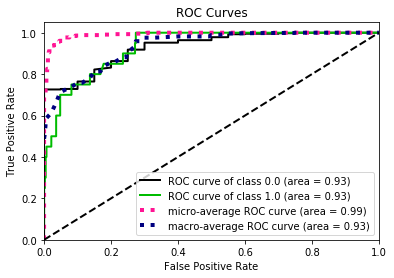

In [22]:
plt.figure(figsize=(10,5))
skplt.metrics.plot_roc_curve(Y_val, Y_pred_proba)

<a id="ch5.2"></a>
### 5.2. Features importance

Throughout the processing step, we have attracted a lot of new features. Now let's see how each feature contribute to the classification result

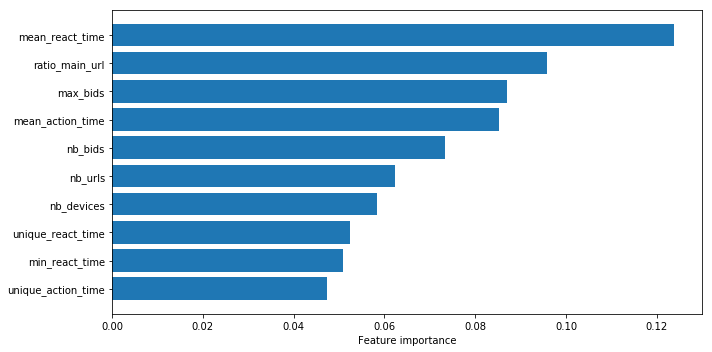

In [24]:
features_imp = pd.DataFrame()
features_imp['features'] = list(train)[2:]
features_imp['importance'] = clf_chosen.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

y = -np.arange(10)
plt.figure(figsize=(10,5))
plt.barh(y, features_imp.loc[:9,'importance'].values)
plt.yticks(y,(features_imp.loc[:9,'features']))
plt.xlabel('Feature importance')
plt.tight_layout()

It can be seen that **`mean_react_time`** is the most important feature, which intuitive makes sense since in general reaction speed is one of the main feature that tells the difference between machine and human. Some other important features are **`ratio_main_url`** and **`max_bids`** and **`mean_action_time`**

<a id="ch5.3"></a>
### 5.3. Conclusion

In this note book we present our approach to classify human/robot in an online auction platform. After extracting features from all the bids and using XGBoost algorithm, we achieve a validation score of **95%**. However, the value achieved on Kaggle submission site is only **73%** (top 60%). The reason behind this error is that lots of human user has characteristics behavior similar to that of robots, and the training data is highly unbalanced with lots of human and very few robots. We try to solve this problem by using an ensemble algorithm like XGBoost and upsample the training data. The final results reveals that the **react time**, **number of bids in an auction** and **action time** of the bidders are the most important features to distinguish between human and robots.